# Alkım Ege Akarsu | 21901461 | CS 464 | HW2 | Q1

## Package Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from os import listdir

## Functions

In [2]:
def load_images():
    """Load images from the datasets directory.

    Returns:
        ndarray of shape (3000, 3600): Loaded and flattened images.
    """
    # Prepare image storage
    result = np.zeros((3000, 3600))
    # Get dataset directory
    dataset_path = Path().resolve().joinpath("datasets", "q1_dog")
    # Get list of files inside directory
    file_paths = [dataset_path.joinpath(file_name) for file_name in listdir(dataset_path)]
    # Loop over file list and import images
    for i, image_path in enumerate(file_paths):
        # Load image
        result[i] = plt.imread(image_path).flatten()
    
    return result


def standardize_images(dataset):
    """Standardize dataset.

    Args:
        dataset (ndarray): Dataset to be standardized.

    Returns:
        ndarray: Standardized dataset.
        ndarray: Original mean.
        ndarray: Original standard deviation.
    """
    # Copy dataset to avoid overwriting
    dataset_copy = dataset.copy()
    # Get original mean and standard deviation
    orig_mean = np.mean(dataset, axis=0)
    orig_std = np.std(dataset, axis=0)
    # Standardize dataset
    dataset_copy -= orig_mean
    dataset_copy /= orig_std
    
    return dataset_copy, orig_mean, orig_std


def unstandardize_images(standardized_dataset, orig_mean, orig_std):
    """Unstandardize dataset.

    Args:
        dataset (ndarray): Dataset to be unstandardized.
        orig_mean (ndarray): Original mean.
        orig_std (ndarray): Original standard deviation.

    Returns:
        ndarray: Unstandardized dataset.
    """
    # Copy dataset to avoid overwriting
    dataset_copy = standardized_dataset.copy()
    # Unstandardize dataset
    dataset_copy *= orig_std
    dataset_copy += orig_mean
    
    return dataset_copy


def get_eigens(dataset):
    """Compute eigendecomposition of dataset.

    Args:
        dataset (ndarray): Dataset to be decomposed.
            Columns are features, rows are samples.

    Returns:
        ndarray: Sorted eigenvalues.
        ndarray: Sorted eigenvectors.
    """
    # Compute covariance matrix of dataset
    cov = np.cov(dataset, rowvar=False)
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    # Discard imaginary parts
    eigenvalues, eigenvectors = np.real(eigenvalues), np.real(eigenvectors)
    # Sort eigenvalues in descending order
    sorted_indices = np.flip(np.argsort(eigenvalues))
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    
    return sorted_eigenvalues, sorted_eigenvectors

## PCA

In [3]:
# Load dataset
dataset = load_images()
# Standardize dataset
dataset_standardized, orig_mean, orig_std = standardize_images(dataset)

### 1.1

<StemContainer object of 3 artists>

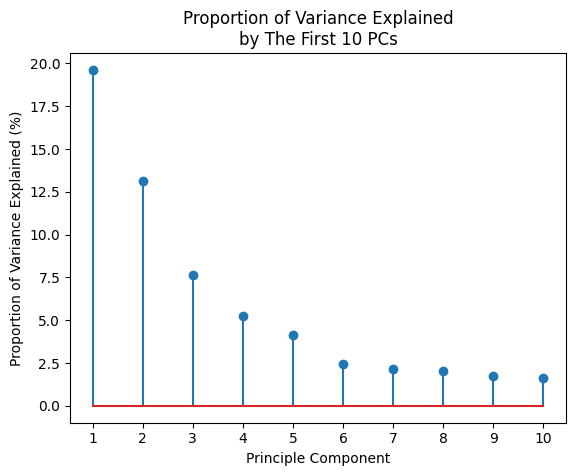

In [4]:
# Get sorted eigenvalues and eigenvectors (PCs)
sorted_eigenvalues, sorted_eigenvectors = get_eigens(dataset_standardized)
# Calculate proportion of variance explained by each PC
prop_variance_explained = sorted_eigenvalues / np.sum(sorted_eigenvalues)
# Plot proportion of variance explained for the first 10 PCs
plt.figure()
plt.title("Proportion of Variance Explained\nby The First 10 PCs")
plt.xlabel("Principle Component")
plt.ylabel("Proportion of Variance Explained (%)")
plt.xticks(np.arange(1, 11))
plt.stem(np.arange(1, 11), prop_variance_explained[:10] * 100)

The goal of PCA is to reorient the axes to capture the most amount of variance using the least amount of dimensions. In this case, we assume that variance is positively correlated with usefulness. So, when proportion of variance explained (PVE) of a PC is large, we understand that that PC is more useful compared to other PCs. PVE of a PC is an important metric because if we have a total variance explained target we can select PCs starting from the one that explains the most amount of variance and keep selecting the PCs with the next largest PVE values until the total PVE is larger than or equal to our target.

### 1.2

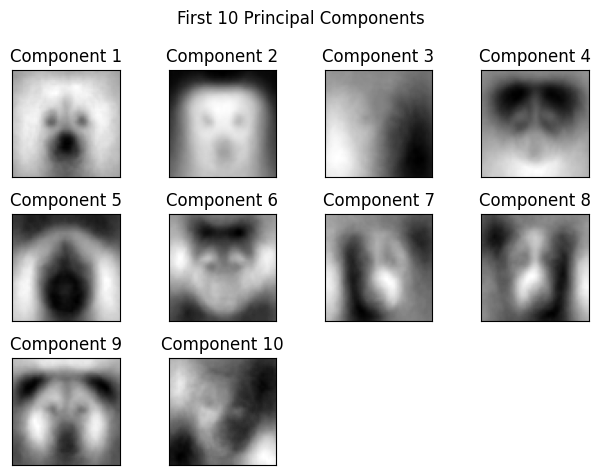

In [5]:
# Reshape PCs
reshaped_eigenvectors = sorted_eigenvectors.reshape(60, 60, 3600)
# Display the first 10 PCs
plt.figure()
plt.suptitle("First 10 Principal Components")
for i in range(10):
    image = reshaped_eigenvectors[:, :, i].reshape(60, 60)
    plt.subplot(3, 4, i + 1)
    plt.title(f"Component {i + 1}")
    plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.imshow(image, cmap="gray")
plt.tight_layout()

The principal components represent directions that contain the most amount of variance. The images of principal components represent the patterns that capture the most amount of variance. They can also be understood as the "building blocks" of each individual image.

### 1.3

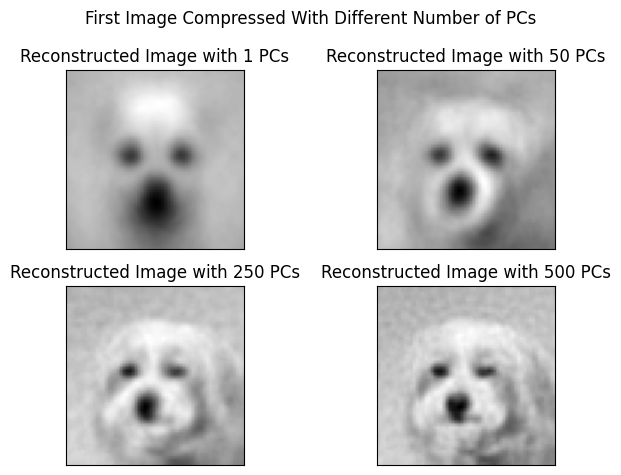

In [6]:
# Prepare the figure
plt.figure()
plt.suptitle("First Image Compressed With Different Number of PCs")
# Loop over PC number values
for i, k in enumerate([1, 50, 250, 500]):
    # Get first image
    flat_image = dataset_standardized[0, :]
    # Project the image
    projected_image = np.dot(flat_image, sorted_eigenvectors[:, :k])
    # Reconstruct the image
    reconstructed_image = np.dot(projected_image, sorted_eigenvectors[:, :k].T)
    # Unstandardize the image
    reconstructed_image = unstandardize_images(reconstructed_image, orig_mean, orig_std)
    # Reshape the image
    image = reconstructed_image.reshape(60, 60)
    # Display the image
    plt.subplot(2, 2, i + 1)
    plt.title(f"Reconstructed Image with {k} PCs")
    plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.imshow(image, cmap="gray")
plt.tight_layout(w_pad=5)

First step of image compression using PCA is projecting the image to the principal component space. Then, the dot product of the projection and the transpose of the PCs result in the compressed image.
The quality of the compressed image increases as the number of PCs used for compression (k) increase. Since each PC explains a portion of total variance, as more PCs are considered, more of the total variance is represented. If we use all PCs, we get a lossless reconstruction of the original image.